# Introduction
This notebook is an implementation of the twitter sentiment analysis that will be used to predict the price of bitcoin based on the sentiment gathered from the tweets. Data will be saved in an sql database to make it possible to create a datawarehouse that can be used over time for more analysis.

# Importing Libraries

In [10]:
import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk
import pycountry
import re
import string

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer

# Twitter Authentication

In [13]:
import datetime
import nltk
nltk.downloader.download('vader_lexicon')
client=tweepy.Client(bearer_token='AAAAAAAAAAAAAAAAAAAAAAfVlQEAAAAA8pctnhfuuAiNvqOj%2FeXaAXzlQ%2Fs%3D9YoRCaJG6cViLtEhDY7oeSMVJrelLm4DC4djXlp9zMBt0i4Icm')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kinut\AppData\Roaming\nltk_data...


# Data Collection

In this step we collect data by retrieving the tweets using the tweepy library.

In [14]:
def percentage(part, whole):
    return 100 * float(part)/float(whole)


today = datetime.datetime.now()
today = today.replace(hour=23, minute=59, second=59, microsecond=999999)
time_to_the_past = 6
yesterday = today - datetime.timedelta(time_to_the_past)

keyword = "bitcoin btc"
noOfTweet = 1000
next_day = yesterday + datetime.timedelta(time_to_the_past)

query = '#bitcoin lang:en'
tweets = client.search_recent_tweets(query=query, tweet_fields=['context_annotations', 'created_at'], max_results=100)
#print(tweets)
positive = 0
negative = 0
neutral = 0
polarity = 0
tweet_list = []
neutral_list = []
negative_list = []
positive_list = []
for tweet in tweets.data:
 tweet_list.append(tweet.text)
 analysis = TextBlob(tweet.text)
 score = SentimentIntensityAnalyzer().polarity_scores(tweet.text)
 neg = score['neg']
 neu = score['neu']
 pos = score['pos']
 comp = score['compound']
 polarity += analysis.sentiment.polarity

 if neg > pos:
  negative_list.append(tweet.text)
  negative += 1
 elif pos > neg:
  positive_list.append(tweet.text)
  positive += 1

 elif pos == neg:
  neutral_list.append(tweet.text)
  neutral += 1
positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.1f')
negative = format(negative, '.1f')
neutral = format(neutral, '.1f')


### Results of the retrieved tweets

In [15]:
tweet_list = pd.DataFrame(tweet_list)
neutral_list = pd.DataFrame(neutral_list)
negative_list = pd.DataFrame(negative_list)
positive_list = pd.DataFrame(positive_list)
print("total number of tweets: ",len(tweet_list))
print("positive number of tweets: ",len(positive_list))
print("negative number of tweets: ", len(negative_list))
print("neutral number of tweets: ",len(neutral_list))

total number of tweets:  100
positive number of tweets:  47
negative number of tweets:  21
neutral number of tweets:  32


## Visualizing the scores of the uncleaned data

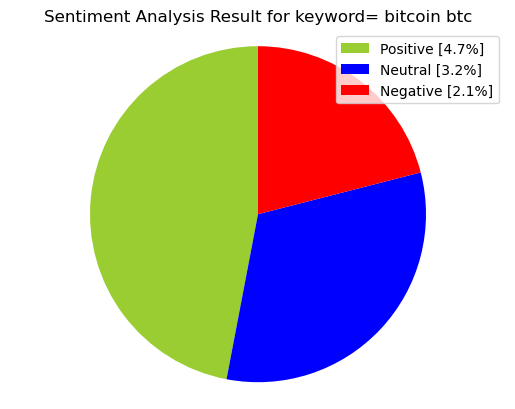

In [16]:
labels = ['Positive ['+str(positive)+'%]' , 'Neutral ['+str(neutral)+'%]','Negative ['+str(negative)+'%]']
sizes = [positive, neutral, negative]
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title("Sentiment Analysis Result for keyword= "+keyword+"" )
plt.axis('equal')
plt.show()

### Displaying the retrieved tweets

In [17]:
tweet_list

,0
0,RT @BTC_Archive: ‼️ White House Cryptocurrency...
1,RT @alanbwt: Nostr feels like a zero to one mo...
2,RT @CryptoQueenUSA: Just because supply goes d...
3,@CoinDesk @realMatrixport @godbole17 #bitcoin ...
4,RT @WatcherGuru: The top 100 richest #Bitcoin ...
...,...
95,RT @saylor: Stocks valued on expected cash flo...
96,RT @BitcoinMagazine: BREAKING: 🇺🇸 White House ...
97,"RT @Kenslog: Good morning friends, I won 5500 ..."
98,RT @CoinMarketCap: Let's debunked the seven bi...


# Data Preparation

The first step of data preparation is dropping any duplicate tweets

### Dropping duplicates

In [18]:
tweet_list.drop_duplicates(inplace = True)

The new list after the duplicates are dropped becomes:

In [19]:
tweet_list

,0
0,RT @BTC_Archive: ‼️ White House Cryptocurrency...
1,RT @alanbwt: Nostr feels like a zero to one mo...
2,RT @CryptoQueenUSA: Just because supply goes d...
3,@CoinDesk @realMatrixport @godbole17 #bitcoin ...
4,RT @WatcherGuru: The top 100 richest #Bitcoin ...
...,...
94,RT @Jcastweet: Adopting #Bitcoin ⚡️ payments m...
95,RT @saylor: Stocks valued on expected cash flo...
97,"RT @Kenslog: Good morning friends, I won 5500 ..."
98,RT @CoinMarketCap: Let's debunked the seven bi...


### Removing special characters, RT and punctuations

In [20]:
tw_list = pd.DataFrame(tweet_list)
tw_list["text"] = tw_list[0]
remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
rt = lambda x: re.sub("(@[A-Za-z0–9]+)|([0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x)
tw_list["text"] = tw_list.text.map(remove_rt).map(rt)
tw_list["text"] = tw_list.text.str.lower()

A preview of the first 5 rows is shown below

In [22]:
tw_list.head(5)

,0,text
0,RT @BTC_Archive: ‼️ White House Cryptocurrency...,‼️ :\n• ...
1,RT @alanbwt: Nostr feels like a zero to one mo...,...
2,RT @CryptoQueenUSA: Just because supply goes d...,", ' ..."
3,@CoinDesk @realMatrixport @godbole17 #bitcoin ...,# ...
4,RT @WatcherGuru: The top 100 richest #Bitcoin ...,# ...


# Sentiment Analysis

Now that our data is cleaned we can conduct sentiment analysis to obtain sentiments from the data.

In [23]:
tw_list[['polarity', 'subjectivity']] = tw_list['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in tw_list['text'].iteritems():
 score = SentimentIntensityAnalyzer().polarity_scores(row)
 neg = score['neg']
 neu = score['neu']
 pos = score['pos']
 comp = score['compound']
 if neg > pos:
  tw_list.loc[index, 'sentiment'] = "negative"
 elif pos > neg:
  tw_list.loc[index, 'sentiment'] = "positive"
 else:
  tw_list.loc[index, 'sentiment'] = "neutral"
  tw_list.loc[index, 'neg'] = neg
  tw_list.loc[index, 'neu'] = neu
  tw_list.loc[index, 'pos'] = pos
  tw_list.loc[index, 'compound'] = comp
tw_list.head(10)

,0,text,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,RT @BTC_Archive: ‼️ White House Cryptocurrency...,‼️ :\n• ...,0.0,0.0,neutral,0.0,1.0,0.0,0.0
1,RT @alanbwt: Nostr feels like a zero to one mo...,...,0.0,0.0,neutral,0.0,0.0,0.0,0.0
2,RT @CryptoQueenUSA: Just because supply goes d...,", ' ...",0.0,0.0,neutral,0.0,0.0,0.0,0.0
3,@CoinDesk @realMatrixport @godbole17 #bitcoin ...,# ...,0.0,0.0,neutral,0.0,0.0,0.0,0.0
4,RT @WatcherGuru: The top 100 richest #Bitcoin ...,# ...,0.0,0.0,neutral,0.0,0.0,0.0,0.0
5,RT @WatcherGuru: FUN FACT: #Bitcoin miners gen...,: # $ ...,0.0,0.0,neutral,0.0,0.0,0.0,0.0
6,RT @TrustWallet: #Bitcoin future price predict...,# : \n\n ...,0.0,0.0,neutral,0.0,0.0,0.0,0.0
7,"RT @BitcoinSapiens: ""#Bitcoin is the only majo...","""# ...",0.0,0.0,neutral,0.0,1.0,0.0,0.0
8,RT @saylor: My discussion with @natbrunell on ...,...,0.0,0.0,neutral,0.0,1.0,0.0,0.0
9,RT @cryptorecruitr: Unpopular opinion: Altcoin...,: #...,0.0,0.0,neutral,0.0,0.0,0.0,0.0


In [24]:
tw_list_negative = tw_list[tw_list["sentiment"]=="negative"]
tw_list_positive = tw_list[tw_list["sentiment"]=="positive"]
tw_list_neutral = tw_list[tw_list["sentiment"]=="neutral"]

#### Statistics

In [26]:
def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,"sentiment")

,Total,Percentage
neutral,92,100.0


## Plotting the cleaned data

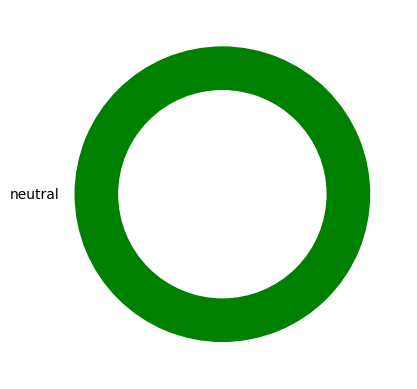

In [27]:
pc = count_values_in_column(tw_list,"sentiment")
names= pc.index
size=pc["Percentage"]
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['green','blue','red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Conclusion
The sentiment analysis above can help us understand and predict the price of bitcoin because if the majority of the tweets have a neutral sentiment then the price is not likely to go down or go up but if it was positive then the price is likely to go up and for negative the price is likely to go down